# INF8825 - Travail pratique 2
___

Claudia Onorato (1845448)

Les deux parties de ce travail ont été réalisé avec William Harvey (1851388).

## Partie I
____

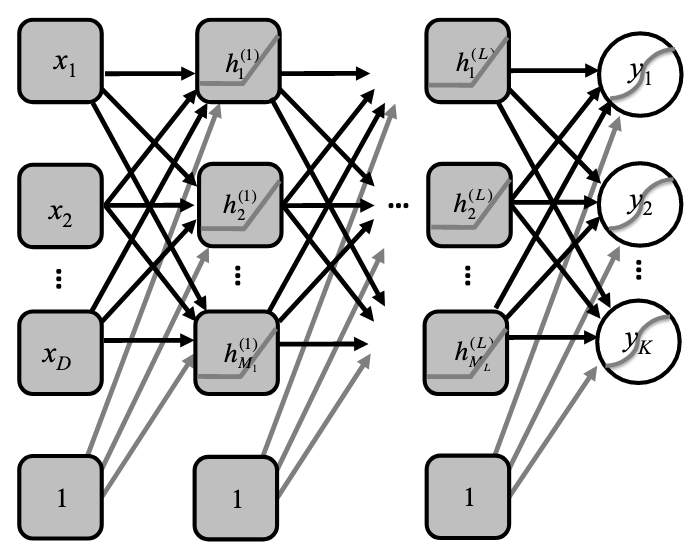

### a) Pseudocode de l'algorithme de rétropropagation
___

L'algorithme de rétropropagation se base sur le calcul de gradients afin d'ajuster tous les poids du modèle en minimisant la fonction de coût. 

La fonction de coût correspond à la cross-entropy lié au softmax: $$L = -\sum_{i=1}^{K} y_i \log(f_i)$$

Comme on peut voir ci-dessous dans l'arbre de dépendance des la fonction de coût, celle-ci dépend directement de la fonction d'activation de la dernière couche. Celle-ci est softmax:

$$f_k = \frac{exp(a_k^{(L+1)})}{\sum_{c=1}^K exp{(a_c^{(L+1)})}}$$

Le résultat de la préactivation équivaut quant à elle à $a^{(L+1)} = \theta^{(L+1)}\hat{h}^{(L)}$.

Par la suite, le calcul de l'activation des couches cachées se font par la fonction `ReLU`: $h^{(L)} = ReLU(a^{(L)})$. 

Afin de bien comprendre les calculs des gradients, il est important de voir la dépendance entre les différentes fonctions et couches. Ci-dessous, nous avons, à la gauche, les dépendances de la dernière couche, suivant la notation de l'énoncé. Ensuite, une exemple d'une couche cachée au centre, puis la première couche à droite.


```
                      θ(L+1)   h(L)        θ(L)    h(L-1)          θ(1)     x 
                        ^       ^           ^       ^               ^       ^            
                        |       |           |       |               |       |        
                        +---+---+           +---+---+               +---+---+          
                            +                   |                       |                 
                          a(L+1)               a(L)        ...         a(1)                    
                            ^                   ^                       ^            
                            |                   |                       |            
                   y        f                   |                       |           
                   ^        ^                  h(L)                    h(1)      
                   |        |
                   +----+---+
                        |
                        +
                        L

```

Pour les calculs des gradients, observons d'abord la dernière couche. Nous allons utiliser la dérivation en chaîne:

$$\frac{\delta L}{\delta\theta^{(L+1)}} = \frac{\delta L}{\delta f} \frac{\delta f}{\delta a^{(L+1)}} \frac{\delta a^{(L+1)}}{\delta\theta^{(L+1)}} $$

$$\frac{\delta L}{\delta\theta^{(L+1)}} = -(y - f^{(L+1)}))\hat{h}^{(L)} = -\Delta^{(L+1)} \hat{h}^{(L)T}$$

Pour les poids des couches cachées, nous calculons les gradients de cette manière, en se basant sur les dérivées partielles des couches supérieures: 

$$\frac{\delta L}{\delta\theta^{(l)}} = -\Delta^{(l)} \frac{\delta a^{(l)}}{\delta\theta^{(l)}}$$

Où:

$$\Delta^{(l)} = \frac{\delta \hat{h}^{(l)}}{\delta a^{(l)}} \frac{\delta a^{(l+1)}}{\delta \hat{h}^{(l)}}\Delta^{(l+1)} = D^{(l)}W^{(l+1)}\Delta^{(l+1)}$$

et

$$\frac{\delta a^{(l)}}{\delta\theta^{(l)}} = \hat{h}^{(l-1)}$$

On a alors:

$$\frac{\delta L}{\delta\theta^{(l)}} = D^{(l)}W^{(l+1)}\Delta^{(l+1)}\hat{h}^{(l-1)}$$

Le calcul de la première couche se fait de la même manière, en remplaçant $\hat{h}^{(l-1)}$ par $\hat{x}$.

Nous pouvons alors formuler le pseudocode suivant:


```python
"""
Entrée:
    theta: 
        vecteurs de poids de dimension
            (M,D+1) pour la 1ere couche,
            (M,M+1) pour les L-1 autres couches cachées et
            (K,M+1) pour la L+1 dernière couche;
    f:
        valeurs d'activation softmax de dimension (K,1)        
    h:
        1 vecteur des valeurs d'entrée de taille (D + 1,1), auxquels on concatène un 1 (pour le biais)
            suivi de
        L vecteurs d'activation de dimension (M + 1,1), auxquels on concatène un 1 (pour le biais).
    a:
        L vecteurs de valeurs de préactivation (M,1)
        1 vecteur de préactivation de taille (K,1) pour la dernière couche
    y:
        One-hot vecteur de la valeur attendue de l'observation de taille (K,1)

Sortie:
    gradients:
        vecteurs de gradients de dimensions
            (M,D+1) pour la 1ere couche,
            (M,M+1) pour les L-1 autres couches cachées et
            (K,M+1) pour la L+1 dernière couche;

Procédure:
"""

# 1. Calcul du gradient pour la dernière couche

current_delta = (y - f)
grads[L+1] = - current_delta * h[L]
previous_delta = current_delta

# 2. On calcule les gradients de l'avant dernière à la première couche
Pour chaque couche l de L à 1:
    
    # 2.1 On calcule la vecteur d qui contient les éléments de la diagonale de D
    #     Contient la dérivée de la fonction d'activation ReLU en fonction de a
    d = [1 if a_element > 0 for a_element in a[l] else 0]
    
    # 2.2 On calcule le delta pour la couche courante où on ignore les biais dans theta
    current_delta = d * (theta[l+1][:,:-1] * previous_delta)
    
    # 2.3 On calcule les gradients pour la couche courante
    grads[l] = - current_delta * h[l-1]
    
    # 2.4 On sauvegarde le delta de la couche courante pour la calcul de la couche (l-1).
    previous_delta = current_delta
    
Retourner grads
```

### b) Implémentation avec et sans Pytorch et comparaison
___

#### 0. Chargement du jeu de données
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
train_set = FashionMNIST(
    root = './data/train-FashionMNIST',
    train = True,
    download = True
)

valid_set = FashionMNIST(
    root = './data/valid-FashionMNIST',
    train = False,
    download = True
)

In [3]:
train_set.train_data.shape

/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [4]:
train_set.train_labels.shape

/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000])

Expected image is Trouser


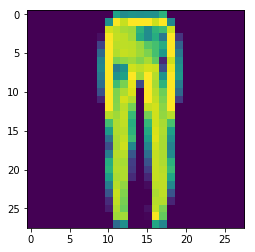

In [5]:
TRAIN_EXAMPLE = 4040
print(f"Expected image is {train_set.classes[train_set.train_labels[TRAIN_EXAMPLE]]}")
plt.imshow(train_set.train_data[TRAIN_EXAMPLE].numpy())

In [6]:
valid_set.data.shape

torch.Size([10000, 28, 28])

Expected image is Trouser


/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


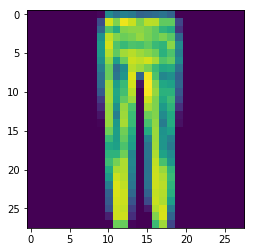

In [7]:
TEST_EXAMPLE = 4039
print(f"Expected image is {valid_set.classes[valid_set.test_labels[TEST_EXAMPLE]]}")
plt.imshow(valid_set.test_data[TEST_EXAMPLE].numpy())

Convertion en one-hot et en vecteurs 1D

In [8]:
from keras.utils import to_categorical

train_X = train_set.train_data.numpy().reshape(train_set.train_data.numpy().shape[0], -1)
train_y = to_categorical(train_set.train_labels.numpy(), num_classes=10)

test_X = valid_set.test_data.numpy().reshape(valid_set.test_data.numpy().shape[0], -1)
test_y = to_categorical(train_set.train_labels.numpy(), num_classes=10)

train_X = train_X / 255.
test_X = test_X / 255.

print(f"Train set X: {train_X.shape} with y: {train_y.shape}")
print(f"Test set X: {test_X.shape} with y: {test_y.shape}")

Using TensorFlow backend.
/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Train set X: (60000, 784) with y: (60000, 10)
Test set X: (10000, 784) with y: (60000, 10)


#### 1. Implémentation sans Pytorch
___

Lors de l'implémentation à la main du réseau de neurones, j'ai consulté [cet article](https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb) qui monte un réseau de neurones ayant seulement une couche cachée et utilisant les fonctions d'activation sigmoid.

In [216]:
class HandmadeNetwork():
    
    def __init__(self, nb_hidden_layers, nb_inputs=784, nb_units_per_layer=300, nb_class=10):
        self.nb_units_per_layers = [nb_inputs] + [nb_units_per_layer] * nb_hidden_layers + [nb_class]
        self.weights = []
        self.bias = []
        
        for i in range(len(self.nb_units_per_layers)-1):
            print(f"{i}th layer: {self.nb_units_per_layers[i]} -> {self.nb_units_per_layers[i+1]}")
            self.weights.append(
                np.random.normal(0, 0.1, (
                    self.nb_units_per_layers[i+1], 
                    self.nb_units_per_layers[i]
                )))
            self.bias.append(np.random.normal(0, 0.1, (
                    self.nb_units_per_layers[i+1])))

        print(f"Number of weight vectors: {len(self.weights)}")
        print(f"Number of units per layer: {self.nb_units_per_layers}")
        
    
    def fit_transform(self, x, y, batch_size=10, epochs=10, lr = 0.01):
        """
        Updates weights and biases in theta matrix according to this training set
        
        x: inputs of size (nb_inputs=784,)
        y: one-hot encoded vector of size (nb_class=10,)
        batch_size: nb of observations to include in a batch
        epochs: nb of iteration of training over the set
        lr: learning rate
        """
        losses = []
        for e in range(epochs): 
            print(f"Epoch {e}\n")
            i=0
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                grads_w = []
                grads_b = []
                for x_elem, y_elem in zip(x_batch, y_batch):
                    a_s, h_s = self._feedforward(x_elem)
                    dw, db = self._backpropagation(y_elem, a_s, h_s)
                    grads_w.append(dw)
                    grads_b.append(db)

                grads_w = [[grad[i] for grad in grads_w] for i in range(len(grads_w[0]))]
                grads_b = [[grad[i] for grad in grads_b] for i in range(len(grads_b[0]))]

                self.weights = [weights - lr * np.mean(grad) for weights, grad in  zip(self.weights, grads_w)]
                self.bias = [bias - lr * np.mean(grad) for bias, grad in  zip(self.bias, grads_b)]
    
                y_pred = [self.predict(x_elem) for x_elem in x_batch]
                losses.append(self.get_loss(y_batch, y_pred))
            
                i += batch_size

        return losses
    
    def predict(self, x):
        _, h_s = self._feedforward(x)
        return h_s[-1]
    
    def _feedforward(self, x):
        """
        Returns the preactivation and activation values for each layers after forwarding one observation
        
        input
            x: observations of dim (784,)
            
        returns:
            a_s: (avant z_s) preactivation values for each layers and each units
                ** pas de +1 pour le biais dans les dimensions **
            h_s: (avant a_s) activation values for each layers and each units
                Note: last h values corresponds to the activation values f associated with softmax.
                Note: first h values corresponds to the activation values of the input layer, whereas the input x.
                ** pas de +1 pour le biais dans les dimensions **
        """
        h = np.copy(x)
        a_s = []
        h_s = [h]
        
        for i in range(len(self.weights)):
            a = np.add(np.dot(self.weights[i], h), self.bias[i])
            a_s.append(a)
            
            if i == len(self.weights) - 1:
                # calculates last layer activation with stable softmax
                h = self.softmax(a)
                h_s.append(h)
            else:
                # calculates activation with ReLU
                h = self.relu(a)
                h_s.append(h)    

        return a_s, h_s
    
    def _backpropagation(self,y, a_s, h_s):
        """
        Returns the negative gradients for each layers for one observation
        
        Input:
            y: one-hot encoded labels
            a_s: (avant z_s) preactivation values for each layers and each units
                ** pas de +1 pour le biais dans les dimensions **
            h_s: (avant a_s) activation values for each layers and each units
                Note: last h values corresponds to the activation values f associated with softmax.
                Note: first h values corresponds to the activation values of the input layer, whereas the input x.
                ** pas de +1 pour le biais dans les dimensions **
        Returns:
            dtheta: gradient for each weight and biases
        """
        L = len(self.weights)
        dw = [None] * len(self.weights) # dC/dw
        db = [None] * len(self.bias) # dC/db
        
        delta = (y - h_s[-1]) 
        dw[-1] = -np.dot(delta.reshape(delta.shape[0],1), h_s[-2].reshape(h_s[-2].shape[0],1).T)
        db[-1] = -np.sum(delta, axis=0, keepdims=True)
        previous_delta = delta
        
        for l in reversed(range(0, L-1)):
            d = self.relu_differential(a_s[l])
        
            delta = d * (self.weights[l+1].T.dot(previous_delta))    
            dw[l] = - np.dot(delta.reshape(delta.shape[0],1), h_s[l].reshape(h_s[l].shape[0],1).T)
            db[l] = - np.sum(delta, axis=0, keepdims=True)
            previous_delta = delta

        return dw, db
    
    
    def adjust_theta_with_batch(self, weights, bias, grads, lr):
        return (weights - lr * np.mean(grads[0]), bias - lr * np.mean(grads[1]))
        
    @staticmethod
    def relu(x):
        y = np.copy(x)
        y[y<0] = 0
        return y
     
    @staticmethod
    def relu_differential(x):
        y = np.copy(x)
        y[y>=0] = 1
        y[y<0] = 0
        return y
    
    @staticmethod
    def get_hat(h):
        return np.pad(h, (0,1), constant_values=1)
    
    @staticmethod
    def softmax(x):
        # assurez vous que la fonction est numeriquement stable
        # e.g. softmax(np.array([1000, 10000, 100000], ndim=2))
        x = x - max(x)
        exp_sum = sum(np.exp(x))
        return np.exp(x)/exp_sum
    
    @staticmethod
    def get_loss(y, y_pred):
        """
            Returns the loss calculated from the mean negative log likelihood loss function.

            y:      labels of shape (nb_observations, nb_classes)
            y_pred: probabilities for each class and each observation of shape (nb_observations, nb_classes)
        """
        loss = 0
        for i in range(y.shape[0]): # for each observation
            loss += -(y[i] * np.log(y_pred[i])).sum()

        return loss/y.shape[0]

In [217]:
nn = HandmadeNetwork(nb_hidden_layers=2)


0th layer: 784 -> 300
1th layer: 300 -> 300
2th layer: 300 -> 10
Number of weight vectors: 3
Number of units per layer: [784, 300, 300, 10]


In [218]:
train_set.train_data[0].numpy().shape

x = train_set.train_data[0].numpy().flatten()
y = train_set.train_labels[0].numpy()
y_one_hot = np.zeros((y.size, y.max()+1))
y_one_hot[np.arange(y.size),y] = 1

nn.predict(x)

array([3.51537471e-241, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.17547716e-133, 0.00000000e+000,
       1.00000000e+000, 0.00000000e+000])

In [219]:
a_s, h_s = nn._feedforward(x);
grad = nn._backpropagation(y, a_s, h_s)


In [230]:
nn = HandmadeNetwork(nb_hidden_layers=1)

losses = nn.fit_transform(train_X[0:1000], train_y[0:1000], batch_size=10, epochs=10, lr = 0.01)

0th layer: 784 -> 300
1th layer: 300 -> 10
Number of weight vectors: 2
Number of units per layer: [784, 300, 10]
Epoch 0

Epoch 1

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

CPU times: user 7min 1s, sys: 3min 12s, total: 10min 13s
Wall time: 7min 19s


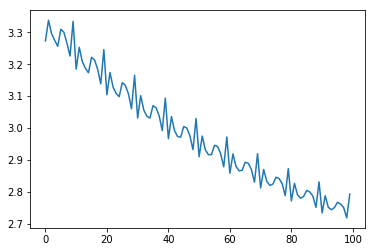

In [231]:
plt.plot(losses)

array([[ 13,  44,   7,   1,  45, 329,   4,   8, 122, 427],
       [  1,   6,  17,   0,   2,  10,   0,   1, 472, 491],
       [  4,  34,   3,  10,  18, 449,   0,   1, 165, 316],
       [  6,  47,   6,   1,  39,  73,   0,   1, 164, 663],
       [  5,  16,   3,   2,   8, 251,   0,   3, 193, 519],
       [  2, 101,  48,  19, 338, 269,  20,  86,  59,  58],
       [ 11,  55,   4,   7,  35, 410,   2,   1, 202, 273],
       [  0,  27,  66,   0, 362,  47,  56, 247,  89, 106],
       [  2,  98,   2,   3, 188, 439,  58,   3, 120,  87],
       [  0,  60,   3,   0,  73, 737,   1,   0,  30,  96]])

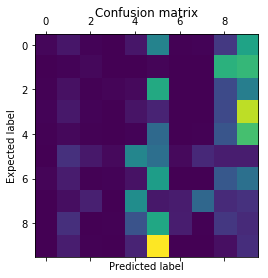

In [232]:
y_pred = [np.argmax(nn.predict(x_elem)) for x_elem in test_X] 
conf = confusion_matrix(valid_set.test_labels.numpy(), y_pred)
plt.matshow(conf)
plt.xlabel("Predicted label")
plt.ylabel("Expected label")
plt.title("Confusion matrix")

conf

In [233]:
print(classification_report(valid_set.test_labels.numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.30      0.01      0.02      1000
           1       0.01      0.01      0.01      1000
           2       0.02      0.00      0.01      1000
           3       0.02      0.00      0.00      1000
           4       0.01      0.01      0.01      1000
           5       0.09      0.27      0.13      1000
           6       0.01      0.00      0.00      1000
           7       0.70      0.25      0.37      1000
           8       0.07      0.12      0.09      1000
           9       0.03      0.10      0.05      1000

    accuracy                           0.08     10000
   macro avg       0.13      0.08      0.07     10000
weighted avg       0.13      0.08      0.07     10000



#### 2. Implémentation avec Pytorch
____

#### 3. Comparaison des deux réseaux
___

## Partie II
____

### 1. Exploration de différents réseaux
____

### 2. Comparaison des différents réseaux
___

### 3. Sélection du meilleur réseau et évaluation avec les données de test
___